In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import nrrd
import os
import pandas as pd
import random
import splitfolders

from scipy import ndimage
from skimage.util import montage

In [2]:
exams_dir = "/home/mainlab1/TCCPauloLucas/data/images/"
masks_dir = "/home/mainlab1/TCCPauloLucas/data/masks/"

In [3]:
IMG_WIDTH = 256
IMG_HEIGTH = 256
IMG_DEPTH = 32
MIN_HU_VALUE = -1000
MAX_HU_VALUE = 400


SLICES_DATA_FOLDER = "sampled_slices_data"
SPLITTED_DATA_FOLDER = "sampled_splitted_data"
TRAIN_IMG_DIR = f"{SPLITTED_DATA_FOLDER}/train/images/"
TRAIN_MASK_DIR = f"{SPLITTED_DATA_FOLDER}/train/masks/"
NODULE_SLICES_ONLY = True

In [4]:
def get_nrrd_data(path):
    # load image from file
    ct_data, ct_header = nrrd.read(path)
    # Get spacing
    ct_spacing = np.asarray([ct_header['space directions'][0, 0],
                             ct_header['space directions'][1, 1],
                             ct_header['space directions'][2, 2]])
    return ct_data, ct_spacing

In [5]:
# Source: https://keras.io/examples/vision/3D_image_classification/

def crop_volume(volume, left, top, right, bottom):
    # Remove the background
    croped_volume = volume[:,top:-bottom,
                left:-right]
    return croped_volume

def normalize(volume):
    """Normalize the volume"""
    min = MIN_HU_VALUE
    max = MAX_HU_VALUE
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    return volume

def resize_volume(volume, resize_z_axis=True):
    """Resize across z-axis"""
#     print(f"pre-transpose {volume.shape}")
    volume = volume.transpose(1,2,0)
#     print(f"post-transpose {volume.shape}")
    # Set the desired depth
    desired_depth = IMG_DEPTH
    desired_width = IMG_WIDTH
    desired_height = IMG_HEIGTH
    # Get current depth
    current_depth = volume.shape[-1]
    current_width = volume.shape[0]
    current_height = volume.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    if not resize_z_axis:
        depth_factor = 1
    volume = ndimage.zoom(volume, (width_factor, height_factor, depth_factor), mode='nearest', order=1)
    return volume

def process_scan(volume, is_image=True, resize_z_axis=True):
    """Read and resize volume"""
    # Crop image
    volume = crop_volume(volume, 70, 30, 70, 110)
    # Resize width, height and depth
    volume = resize_volume(volume, resize_z_axis)
    # Normalize only the images
    if is_image:
        # Normalize
        volume = normalize(volume)
    #Cast to float32
    volume = volume.astype("float32")
    return volume

In [6]:
# exam_files = os.listdir(exams_dir)
# mask_files = os.listdir(masks_dir)

# indexes = {}

# for mask_idx, mask in enumerate(mask_files):
#     mask_path = masks_dir + mask
#     indexes[mask_idx] = []
#     if mask.endswith(".nrrd"):
#         volume, _ = get_nrrd_data(mask_path)
#         for slice_idx, each_slice in enumerate(volume.transpose(2,0,1)):
#             if each_slice.any():
#                 indexes[mask_idx] += [slice_idx]
                

In [7]:
files = []
for data_type in ['images','masks']:
    files += glob.glob(f'{SLICES_DATA_FOLDER}/{data_type}/*') + glob.glob(f'{SLICES_DATA_FOLDER}/{data_type}/*')
for f in files:
    os.remove(f)

In [8]:
exam_files = os.listdir(exams_dir)
mask_files = os.listdir(masks_dir)

indexes = {}
random_slices_dict = {}

for mask_idx, mask in enumerate(mask_files):
    mask_path = masks_dir + mask
    indexes[mask_idx] = []
    random_slices_dict[mask_idx] = []
    if mask.endswith(".nrrd"):
        volume, _ = get_nrrd_data(mask_path)
        volume = process_scan(volume.T, is_image=False, resize_z_axis=False)
        no_slices = volume.shape[2]
        try:
            assert np.array_equal(np.unique(volume), np.array([0.,1.]))
        except AssertionError:
            print(f"Mask file path: {mask_path}")
        volume_T = volume.transpose(2,0,1)
        for slice_idx, each_slice in enumerate(volume_T):
            if NODULE_SLICES_ONLY:
                if each_slice.any():
                    np.save(f'./{SLICES_DATA_FOLDER}/masks/{mask[:-5]}-{slice_idx}.npy', each_slice)
                    indexes[mask_idx] += [slice_idx]
                if slice_idx == no_slices - 1:
                    random_slices = np.random.choice(list(set([x for x in range(no_slices)]) - set(indexes[mask_idx])),20)
                    for random_slice_idx in random_slices:
                        random_slices_dict[mask_idx] += [random_slice_idx]
                        random_slice = volume_T[random_slice_idx]
                        np.save(f'./{SLICES_DATA_FOLDER}/masks/{mask[:-5]}-{random_slice_idx}.npy', random_slice)
            else:
                np.save(f'./all_slices_data/masks/{mask[:-5]}-{slice_idx}.npy', each_slice)

In [10]:
for exam_idx, exam in enumerate(exam_files):
    exam_path = exams_dir + exam
    if exam.endswith(".nrrd"):
        volume, _ = get_nrrd_data(exam_path)
        volume = process_scan(volume.T, is_image=True, resize_z_axis=False)
        no_slices = volume.shape[2]
        volume_T = volume.transpose(2,0,1)
        for slice_idx, each_slice in enumerate(volume_T):
            if NODULE_SLICES_ONLY: 
                if slice_idx in indexes[exam_idx]:
                    np.save(f'./{SLICES_DATA_FOLDER}/images/{exam[:-5]}-{slice_idx}.npy', each_slice)
                if slice_idx == no_slices - 1:
                    for random_slice_idx in random_slices_dict[exam_idx]:
                        random_slice = volume_T[random_slice_idx]
                        np.save(f'./{SLICES_DATA_FOLDER}/images/{exam[:-5]}-{random_slice_idx}.npy', random_slice)
            else:
                np.save(f'./all_slices_data/images/{exam[:-5]}-{slice_idx}.npy', each_slice)

In [12]:
if NODULE_SLICES_ONLY:
    splitfolders.ratio(f"/home/mainlab1/TCCPauloLucas/{SLICES_DATA_FOLDER}/", output=SPLITTED_DATA_FOLDER, seed=1337, ratio = (0.8, 0.1, 0.1))
else:
    splitfolders.ratio("/home/mainlab1/TCCPauloLucas/all_slices_data/", output= "all_splitted_data", seed=1337, ratio = (0.8, 0.1, 0.1))

Copying files: 21184 files [00:06, 3313.54 files/s]


In [ ]:
mask_files = os.listdir(TRAIN_MASK_DIR)

for mask_idx, mask in enumerate(mask_files):
    mask_path = TRAIN_MASK_DIR + mask
    if mask.endswith(".nrrd"):
        volume, _ = get_nrrd_data(mask_path)
        try:
            assert np.array_equal(np.unique(volume), np.array([0.,1.]))
        except AssertionError:
            print(f"Mask file path: {mask_path}")

In [13]:
images = os.listdir(TRAIN_IMG_DIR)
masks = os.listdir(TRAIN_MASK_DIR)

In [28]:
index = 1
img_path = os.path.join(TRAIN_IMG_DIR, images[index])
mask_path =os.path.join(TRAIN_MASK_DIR, masks[index])

image = np.array(np.load(img_path)).astype('float')
mask = np.array(np.load(mask_path)).astype('float')

In [29]:
assert (np.unique(mask) == [0,1]).all()

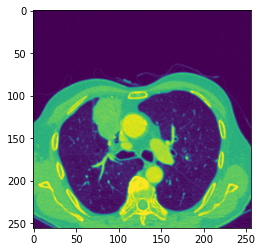

In [30]:
plt.imshow(image)

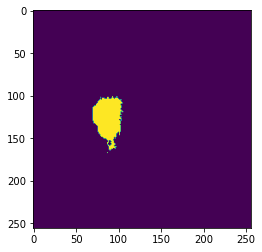

In [31]:
plt.imshow(mask)

# Evaluation


In [45]:
test_files = list(set(file.split('-')[0] + '.nrrd' for file in os.listdir(f"{SPLITTED_DATA_FOLDER}/test/images/")))

In [46]:
for mask_idx, mask in enumerate(test_files):
    mask_path = masks_dir + mask
    if mask.endswith(".nrrd"):
        volume, _ = get_nrrd_data(mask_path)
        volume = process_scan(volume.T, is_image=False, resize_z_axis=False)
        no_slices = volume.shape[2]
        volume_T = volume.transpose(2,0,1)
        for slice_idx, each_slice in enumerate(volume_T):
            np.save(f'./evaluation/masks/{mask[:-5]}-{slice_idx}.npy', each_slice)

In [47]:
for exam_idx, exam in enumerate(test_files):
    exam_path = exams_dir + exam
    if exam.endswith(".nrrd"):
        volume, _ = get_nrrd_data(exam_path)
        volume = process_scan(volume.T, is_image=True, resize_z_axis=False)
        no_slices = volume.shape[2]
        volume_T = volume.transpose(2,0,1)
        for slice_idx, each_slice in enumerate(volume_T):
            np.save(f'./evaluation/images/{exam[:-5]}-{slice_idx}.npy', each_slice)